In [1]:
import numpy as np
import torch
import torch.nn as nn
torch.__version__

'1.6.0'


![Logisticr](./figures/1.8.logistic.png)

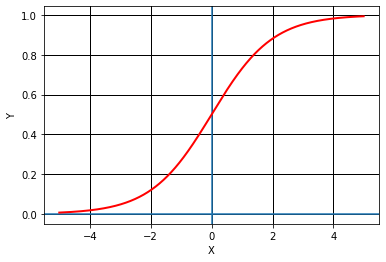

In [2]:
import matplotlib.pyplot as pyplot
x =10.*(torch.rand(500)-0.5).numpy()
y = (torch.rand(500)).numpy()

line_x = 5 * torch.arange(-500,500).float()/500.0
sigmoid_y = torch.sigmoid(line_x)

#print(x[x > 0.5])
pyplot.xlabel('X')
pyplot.ylabel('Y')
#pyplot.plot(x, y, 'bo')
pyplot.axvline(0)
pyplot.axhline(0)
pyplot.grid(color='black', linestyle='-', linewidth=1)
pyplot.plot(line_x , sigmoid_y,'r',linewidth=2, markersize=12)
pyplot.show()

# 1.8 Introduction to logistic regression
In this chapter, we will deal with structured data and use logistic regression to classify structured data simply.
Logistic regression is a statistical model that adopts a logistic function to model a binary dependent
variable, although many more complex extensions exist. In regression analysis, logistic regression
is estimating the parameters of a logistic model in the form of binary regression.
Mathematically, a binary logistic model has a dependent variable with two possible values,
such as "True/False" or "Yes/No" which is represented by an indicator variable $p$ that is labeled with "0" or "1".
Logistic regression is a kind of generalized linear regression (generalized linear model), which has many similarities
with multiple linear regression analysis. Their model formulas are basically the same, both have $wx + \beta$, where $w$ and
$b$ are the parameters to be learned. The major difference lies in their different dependent variables, multiple linear
regression directly uses $wx+\beta$ as the dependent variable, that is, $y = wx+\beta$. However, logistic regression uses the
function $L$ to transform $wx+\beta$ to a new variable $p$, $p = L(wx+\beta)$ where the outcome variable  $p$ is dichotomous
(it can take only two values). If $L$ is a logistic function, it is logistic regression while if $L$ is a polynomial
function,it is polynomial regression.

The general mathematical form of logistic regression is

$l = \log_{b}(\frac{p}{1-p}) = w_{0} + w_{1}x_{1} + ... + w_{k}x_{k}$


The base $b$ of the logarithm is usually taken equal to $e$.
In general, logistic regression will add a layer of a non-linear function on top of a linear regression layer.
Logistic regression is mainly for two-class prediction. We talked about the Sigmoid function in the activation function.
The Sigmoid function is the most common logistic function, because the output of the Sigmoid function is the probability
value between 0 and 1, when the probability is greater than 0.5 is predicted as 1, and less than 0.5 is predicted as 0.
 Sigmoid  is defined as follows:

$\sigma(z) = \frac{1}{1+e^{(z)}}$


Finally the probability $p$ can be defined as:

$p = \frac{1}{1 + e^{-({w_{0} + w_{1}x_{1} + ... + w_{k}x_{k})}}}$

In addition, there is another type of logistic regression called Multinomial Logistic Regression
in which the target variable has three or more possible values. But instead of sigmoid, softmax is adopted that
calculated the probabilities among the desired output classes.

In [3]:

def sigmoid(z):
    return 1/(1+torch.exp(-z))

w = torch.randn(1, 11, requires_grad=True)
b = torch.randn(1, requires_grad=True)

x = torch.randn(1,11)
def logistic_model(x):
    return sigmoid(x @ w.t() + b)


p = logistic_model(x)
print(p)



tensor([[0.5660]], grad_fn=<MulBackward0>)


## Decision boundary

Since the sigmoid activation function outputs a value between 0 and 1, we must define a threshold
to label our prediction as 0 or 1. The most common is to set a threshold at 0.5 where if the prediction
is greater than 0.5, is labeled as 1 where if it's less than 0.5, it's labeled as 0.

In [4]:
decision = (p > 0.5).int()

## 1.8.2 UCI German Credit Data Set

UCI German Credit is UCI's German credit data set, which contains original data and numerical data.
The German Credit data is a data set that predicts the risk on loans based on personal
information and overdue loan applications from customers. The data set contains 1000 pieces of data in 24 dimensions.
This dataset classifies people described by a set of attributes as good or bad credit risks.
Comes in two formats (one all numeric).
Here we directly use the processed numerical data as a display.

[Address](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/)



## Data loading and normalization
Now we can load the data and we arte going to normalize each attribute by calculating
the mean and standard deviation of each feature.


In [5]:
data=np.loadtxt("./data/german.data-numeric")
targets = torch.from_numpy(data)[:,-1][:,None].float()-1.
data_tensor = torch.from_numpy(data)[:,:-1]
means = torch.mean(data_tensor,dim=0)
stds = torch.std(data_tensor,dim=0)
data_tensor = ((data_tensor-means)/stds).float()
print(targets.shape)
print(data_tensor.shape)






torch.Size([1000, 1])
torch.Size([1000, 24])


## Dataset loaders construction
Distinguish between the training set and the test set. Since there is no official verification set here, we can
directly use the accuracy of the test set as the criterion to classify  a sample as  good or bad.

Split dataset: 900 for training and 100 for testing

The format of the dataset is that the first 24 columns are the attributes while the last one is the label
(1 or 2).



In [6]:
split = int(0.9 *len(data_tensor))

train_data = data_tensor[:split,:]
train_targets = targets[:split,:]
test_data = data_tensor[split:,:]
test_targets = targets[split:,:]
batch_size = 32
from torch.utils.data import TensorDataset,DataLoader
training_dataset = TensorDataset(train_data,train_targets)
train_loader = DataLoader(training_dataset, batch_size, shuffle=True)
test_dataset = TensorDataset(test_data,test_targets)

test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
#print(targets)

## Build a logistic regression model
Below we define the model, the model is very simple, a Linear layer (`nn.Linear()`)
 with a Sigmoid activation function (`nn.Sigmoid()`).

In [7]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel,self).__init__()
        self.model = nn.Linear(24,1) # Since 24 dimensions have been fixed, write 24 here
        self.L_function = nn.Sigmoid()
    def forward(self,x):
        y = self.model(x)
        p = self.L_function(y)
        return p




Initialize our model, optimizer and loss functions.
It is a binary classification problem so we'll use `nn.BCELoss`
$BCELoss(y,\hat{y}) = -\frac{1}{N}\sum_{i=0}^{N}(y*\log{\hat{y}}+(1-y)*\log{(1-\hat{y})})$

In [8]:
net = LogisticRegressionModel()
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
epochs = 100 # Number of epochs for training


/home/iliasprc/Documents/penvs/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Let’s start training

In [9]:
for i in range(epochs):
    # Specify the model as training mode and calculate the gradient
    net.train()
    # Input values need to be converted into torch Tensor
    avg_loss = 0.
    total_samples =0.
    correct_predictions = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
         #Clear the loss of the previous step
        optimizer.zero_grad()
        y_hat=net(data)
        loss=criterion(y_hat,target) # calculate loss
        avg_loss+=loss.item()
        pred_label = (y_hat>0.5).int()
        #print(pred_label)
        total_samples += data.size()[0]
        correct_predictions += (pred_label == target).sum()
        loss.backward() # Backpropagation
        optimizer.step() # optimization
        #if (batch_idx+1) % 100 == 0: # Here we output relevant information every 100 times
    print(f'Training Epoch {i} Loss {avg_loss/batch_idx:.2f} Batch = {batch_idx} {correct_predictions/total_samples:.2f}')
        # Specify the model as calculation mode


Training Epoch 0 Loss 0.88 Batch = 28 0.35
Training Epoch 1 Loss 0.86 Batch = 28 0.36
Training Epoch 2 Loss 0.82 Batch = 28 0.39
Training Epoch 3 Loss 0.80 Batch = 28 0.41
Training Epoch 4 Loss 0.76 Batch = 28 0.45
Training Epoch 5 Loss 0.74 Batch = 28 0.48
Training Epoch 6 Loss 0.73 Batch = 28 0.51
Training Epoch 7 Loss 0.71 Batch = 28 0.55
Training Epoch 8 Loss 0.70 Batch = 28 0.58
Training Epoch 9 Loss 0.68 Batch = 28 0.62
Training Epoch 10 Loss 0.66 Batch = 28 0.64
Training Epoch 11 Loss 0.65 Batch = 28 0.66
Training Epoch 12 Loss 0.64 Batch = 28 0.67
Training Epoch 13 Loss 0.63 Batch = 28 0.68
Training Epoch 14 Loss 0.62 Batch = 28 0.69
Training Epoch 15 Loss 0.61 Batch = 28 0.70
Training Epoch 16 Loss 0.60 Batch = 28 0.71
Training Epoch 17 Loss 0.60 Batch = 28 0.72
Training Epoch 18 Loss 0.59 Batch = 28 0.73
Training Epoch 19 Loss 0.58 Batch = 28 0.74
Training Epoch 20 Loss 0.58 Batch = 28 0.74
Training Epoch 21 Loss 0.58 Batch = 28 0.75
Training Epoch 22 Loss 0.56 Batch = 28 0.7

Once the training is complete, let's evaluate now the logistic regression model on the test data.

In [10]:
net.eval()
avg_loss = 0.
total_samples =0.
correct_predictions = 0.
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        y_hat=net(data)
        loss=criterion(y_hat,target) # calculate loss
        avg_loss+=loss.item()
        pred_label = (y_hat>0.5).int()
        total_samples += data.size()[0]
        correct_predictions += (pred_label == target).sum()
    print(f'Test Loss {avg_loss/len(test_loader):.2f} {(correct_predictions/total_samples):.2f} ')


Test Loss 0.48 0.79 


#TODO Multinomial regression



That was a basic introduction to the logistic regression.


